/home/user/anaconda3/envs/dpvo118_backup/lib/python3.10/site-packages/transformers/image_processing_base.py:417: UserWarning: The following named arguments are not valid for `Mask2FormerImageProcessor.__init__` and were ignored: '_max_size', 'reduce_labels'
  image_processor = cls(**image_processor_dict)


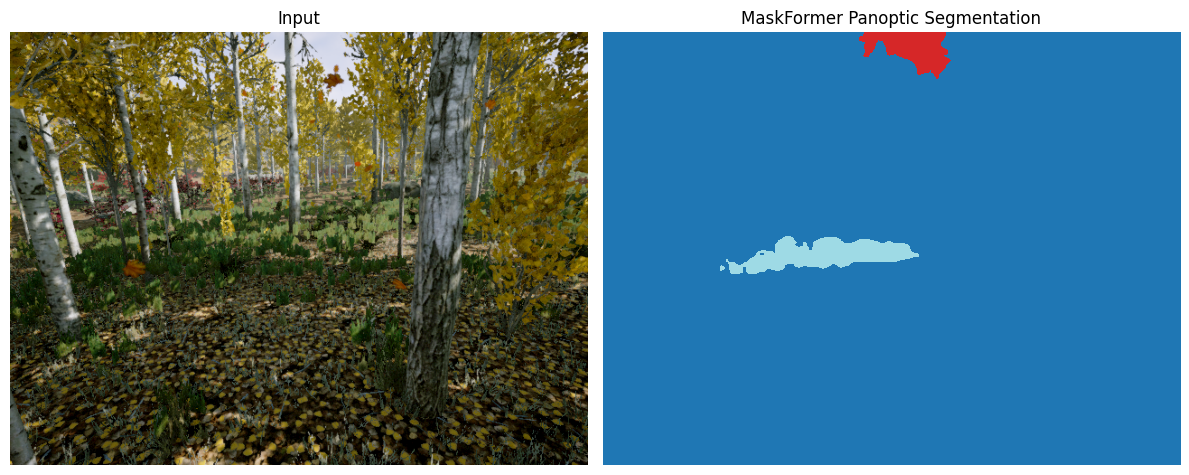

Unique class ids: [116, 119, 125]
Inference avg: 17.62 ms/img (56.76 FPS) over 20 runs


In [2]:
from transformers import AutoImageProcessor, Mask2FormerForUniversalSegmentation
from pathlib import Path
import torch
from PIL import Image
import matplotlib.pyplot as plt
import time


# model = "facebook/mask2former-swin-large-cityscapes-panoptic"  ## Badd
# model = 'facebook/mask2former-swin-large-coco-panoptic' ## Pretty decent
model = 'facebook/mask2former-swin-base-coco-panoptic' ## Pretty decent

seg_processor = AutoImageProcessor.from_pretrained(model)
seg_model = Mask2FormerForUniversalSegmentation.from_pretrained(model)
seg_model = seg_model.eval().to(torch.device('cuda'))

# image1 = Image.open("datasets/mono/ME001/000000.png").convert("RGB") ## Park/Tree/Day/Sunny
# image1 = Image.open("datasets/mono/ME000/000001.png").convert("RGB") ## Abonded Building terrace/ Day/very Sunny/glare
# image1 = Image.open("datasets/mono/ME002/000011.png").convert("RGB") ## cave/forest/dark
# image1 = Image.open("datasets/mono/ME003/000027.png").convert("RGB") ## suburban area/road/car/house
# image1 = Image.open("datasets/mono/ME004/000020.png").convert("RGB") ## underwater
# image1 = Image.open("datasets/mono/ME005/000050.png").convert("RGB") ## indoor offfice
image1 = Image.open("datasets/mono/ME006/000021.png").convert("RGB") ## dense forest
# image1 = Image.open("datasets/mono/ME007/000021.png").convert("RGB") ## desert

seg_inputs = seg_processor(images=image1, return_tensors="pt")
seg_inputs = {k: (v.to(seg_model.device) if isinstance(v, torch.Tensor) else v) for k, v in seg_inputs.items()}

with torch.no_grad():
    seg_outputs = seg_model(**seg_inputs)

# Post-process to obtain semantic segmentation mask at image resolution
seg_result = seg_processor.post_process_semantic_segmentation(
    outputs=seg_outputs, target_sizes=[image1.size[::-1]]
)[0]  # (H, W) tensor with class ids

# Visualize input and segmentation mask
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].imshow(image1)
ax[0].set_title("Input")
ax[0].axis("off")

ax[1].imshow(seg_result.cpu(), cmap="tab20", interpolation="nearest")
ax[1].set_title("MaskFormer Panoptic Segmentation")
ax[1].axis("off")

plt.tight_layout()
plt.show()

# Optional: print unique class ids present
print("Unique class ids:", sorted(set(seg_result.cpu().numpy().ravel().tolist())))

# set your desired save directory
save_dir = f"seg_models/{model}"
Path(save_dir).mkdir(parents=True, exist_ok=True)

_prev_device = next(seg_model.parameters()).device
seg_model.to("cpu")
seg_model.save_pretrained(save_dir)
seg_processor.save_pretrained(save_dir)
seg_model.to(_prev_device)



# Benchmark inference time (forward pass only)
warmup = 5
runs = 20

with torch.no_grad():
    for _ in range(warmup):
        _ = seg_model(**seg_inputs)
if torch.cuda.is_available():
    torch.cuda.synchronize()

t0 = time.perf_counter()
with torch.no_grad():
    for _ in range(runs):
        _ = seg_model(**seg_inputs)
if torch.cuda.is_available():
    torch.cuda.synchronize()
t1 = time.perf_counter()

avg_ms = (t1 - t0) * 1000.0 / runs
fps = 1000.0 / avg_ms
print(f"Inference avg: {avg_ms:.2f} ms/img ({fps:.2f} FPS) over {runs} runs")

In [3]:
seg_model.model.pixel_level_module.encoder.config.output_hidden_states = True
seg_model.model.pixel_level_module.encoder.config.return_dict = True

# Prepare input
from PIL import Image
img = image1
inputs = seg_processor(images=img, return_tensors="pt").to(seg_model.device)
with torch.no_grad():
    # Run the whole model while capturing the backbone output via a forward hook
    _captured = {}
    def _enc_hook(_m, _in, out):
        _captured["bb_out"] = out
    _h = seg_model.model.pixel_level_module.encoder.register_forward_hook(_enc_hook)
    seg_outputs = seg_model(**inputs)
    _h.remove()

bb_out = _captured["bb_out"]


# What you get:
# bb_out.hidden_states -> tuple of tensors after each stage norm (C1..C4)
# bb_out.feature_maps  -> same features but kept in 2D map form (useful for decoder)
print([t.shape for t in bb_out.hidden_states])   # e.g., [(B, H1*W1, C1), ..., (B, H4*W4, C4)]
print([t.shape for t in bb_out.feature_maps])    # e.g., [(B, C1, H1, W1), ..., (B, C4, H4, W4)]

# If you specifically want the output right after patch+pos embedding (pre-stage1),
# take the first element.
c1_tokens = bb_out.hidden_states[0]     # (B, N1, 128) for Swin-B
c4_map    = bb_out.feature_maps[-1]     # (B, 1024, H/32, W/32)

(bb_out.feature_maps[0].shape,  # (B, 128, H/4, W/4) for Swin-B
bb_out.feature_maps[1].shape , # (B, 256, H/8, W/8) for Swin-B
bb_out.feature_maps[2].shape ,# (B, 512, H/16, W/16) for Swin-B
bb_out.feature_maps[3].shape) # (B, 1024, H/32, W/32) for Swin-B

[torch.Size([1, 9216, 128]), torch.Size([1, 9216, 128]), torch.Size([1, 2304, 256]), torch.Size([1, 576, 512]), torch.Size([1, 144, 1024])]
[torch.Size([1, 128, 96, 96]), torch.Size([1, 256, 48, 48]), torch.Size([1, 512, 24, 24]), torch.Size([1, 1024, 12, 12])]


(torch.Size([1, 128, 96, 96]),
 torch.Size([1, 256, 48, 48]),
 torch.Size([1, 512, 24, 24]),
 torch.Size([1, 1024, 12, 12]))

In [ ]:
## Self Attention 

